In [42]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import platform
print(platform.python_version())
import sys
sys.path.append('../../bmtrap')
import matplotlib.pyplot as plt
import numpy as np
import zarr

from coreg import coReg
from preprocessing import BMPreprocessing as BMPrep
from params import BaseParams
from util import *

bmPrep = BMPrep()

3.7.11


In [161]:
toy_dpath = '../../data/TRAP/toy/CFC-5R'
tdTomato_zpath = os.path.join(toy_dpath, "561nm_tdTomato_zarr")
pos_cc_npy = os.path.join(toy_dpath, "tdTomato_prediction_TRAP-20200705-130651_pos_toy.npy")
cfos_zpath = os.path.join(toy_dpath, '642nm_cFOS_zarr')
cfos_ppath = os.path.join(toy_dpath, '642nm_cFOS_probs_zarr')

args = ['trap', '-sz', tdTomato_zpath, '-sc', pos_cc_npy, '-dz', cfos_zpath, '-dp', cfos_ppath, '-thr', '0.5', 
        '-sp', toy_dpath, '-dbg']

p = BaseParams()
p.build(args, 'trap_parser')

zr = [0, 40]
xr = [4900, 5200]
yr = [5700, 6000]

[---------- BaseParams() Variables and their values (BEGIN) ----------]
[ debug ]	: True
[ dst_probpath ]	: /media/share12/MYK/data/TRAP/toy/CFC-5R/642nm_cFOS_probs_zarr
[ dst_tifpath ]	: None
[ dst_zarrpath ]	: /media/share12/MYK/data/TRAP/toy/CFC-5R/642nm_cFOS_zarr
[ save_path ]	: /media/share12/MYK/data/TRAP/toy/CFC-5R
[ src_cc ]	: /media/share12/MYK/data/TRAP/toy/CFC-5R/tdTomato_prediction_TRAP-20200705-130651_pos_toy.npy
[ src_tifpath ]	: None
[ src_zarrpath ]	: /media/share12/MYK/data/TRAP/toy/CFC-5R/561nm_tdTomato_zarr
[ threshold ]	: 0.5
[ viz ]	: False
[---------- BaseParams() Variables and their values (END) ----------]


In [162]:
cr = coReg(p)

In [163]:
cr.load_data()
cr.src_vol.shape, len(cr.src_cc), cr.dst_vol.shape, cr.dst_probs.shape

((40, 10556, 5732), 7896, (40, 10556, 5732), (40, 10556, 5732))

In [164]:
sub_svol, sub_dvol, sub_dpmap = cr.get_subvol(xr=xr, yr=yr, zr=zr)

src_subvol:  (40, 300, 300) dst_subvol:  (40, 300, 300) dst_subprobs:  (40, 300, 300)


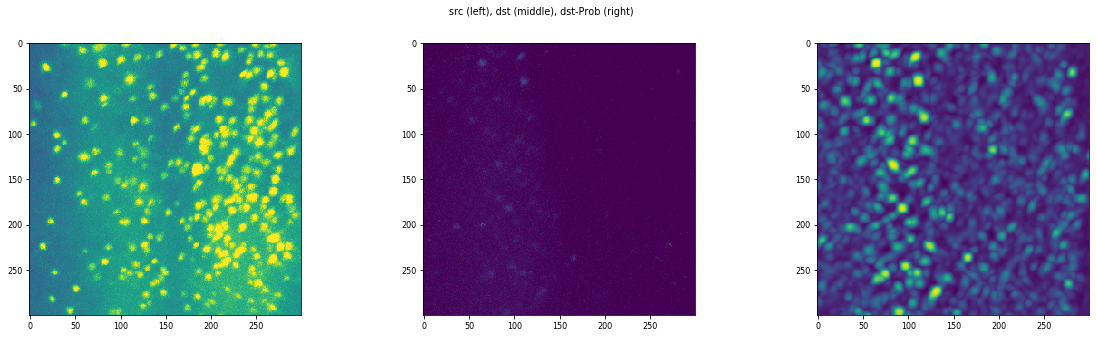

In [165]:
cr.visualize(sub_svol, sub_dvol, sub_dpmap, clim=[100, 600])

In [166]:
cp_ccl = cr.find_coPos(viz=False, save=True)

CoPos: 100%|██████████| 40/40 [02:34<00:00,  3.86s/it]  


len:  40


In [167]:
stacked=[]
for item in cp_ccl:
    stacked += [list(x) for x in item]
stacked_npy = np.array(stacked)

In [168]:
src_sub_cc = cr.get_cc_in_region(cr.src_cc, xr, yr, zr, relative=True)
print("%d / %d selected."%(len(src_sub_cc), len(cr.src_cc)))
src_sub_xs = src_sub_cc[:, 2]
src_sub_ys = src_sub_cc[:, 1]

cp_sub_ccl = cr.get_cc_in_region(stacked, xr, yr, zr, relative=True)
print("%d / %d selected."%(len(cp_sub_ccl), len(stacked)))
cp_ccl_xs = cp_sub_ccl[:, 2]
cp_ccl_ys = cp_sub_ccl[:, 1]

163 / 7896 selected.
18 / 405 selected.


In [171]:
cfos_pmpt = cr.dst_pmap_maxProj.copy()
cfos_pmpt[cfos_pmpt <= cr.params.threshold] = 0.

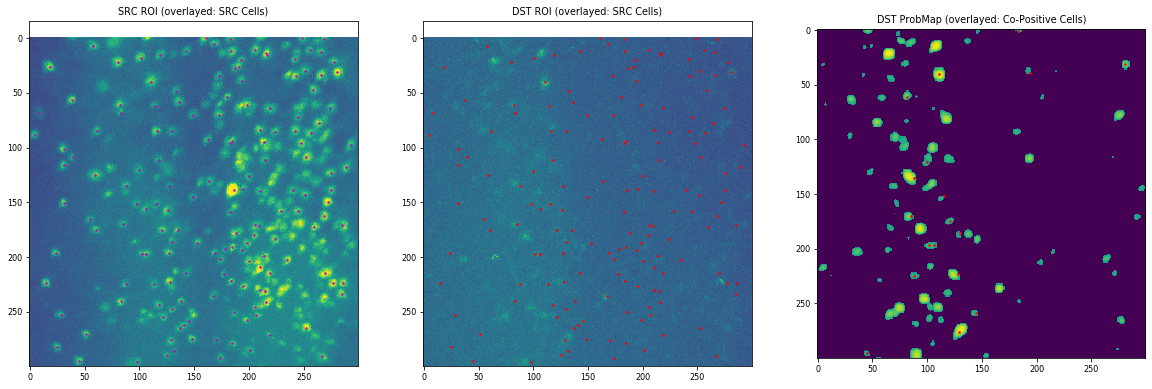

In [173]:
fig = plt.figure(figsize=(20, 8)) 
plt.subplot(131)
plt.imshow(cr.src_maxProj, clim=[100, 800])
plt.scatter(src_sub_xs, src_sub_ys, s=3, c='m', marker='x', alpha=0.8)
plt.title("SRC ROI (overlayed: SRC Cells)")

plt.subplot(132)
plt.imshow(cr.dst_maxProj, clim=[0, 300])
plt.scatter(src_sub_xs, src_sub_ys, s=3, c='r', alpha=0.8)
plt.title("DST ROI (overlayed: SRC Cells)")

plt.subplot(133)
plt.imshow(cfos_pmpt)
plt.scatter(cp_ccl_xs, cp_ccl_ys, s=3, c='r', alpha=0.8)
plt.title("DST ProbMap (overlayed: Co-Positive Cells)")
plt.show()

* Note: if a cell has it's center coordinate outside z-range used for sub-volume extraction (for visualization), it would not be overlayed on the plot above.